In [2]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

Use monthly number of EVs to predict distribution of other vehicle types

**Load data**

In [7]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas fuel','propane']

# CA monthly vehicle distribution

df = pd.read_csv('../data/cleaned/monthly_vehicles.csv')
df.drop(['Unnamed: 0','date','date_idx','total'], axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (96, 9)


,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane
0,522436,305309,10117,590218,1208964,25998612,1298265,8456,93
1,509680,301459,9868,599397,1203595,25917176,1286366,8391,160
2,496924,297609,9619,608576,1198226,25835740,1274467,8326,227
3,484168,293759,9370,617755,1192857,25754304,1262568,8261,294
4,471412,289909,9121,626934,1187488,25672868,1250669,8196,361


**Correlation**

<AxesSubplot: >

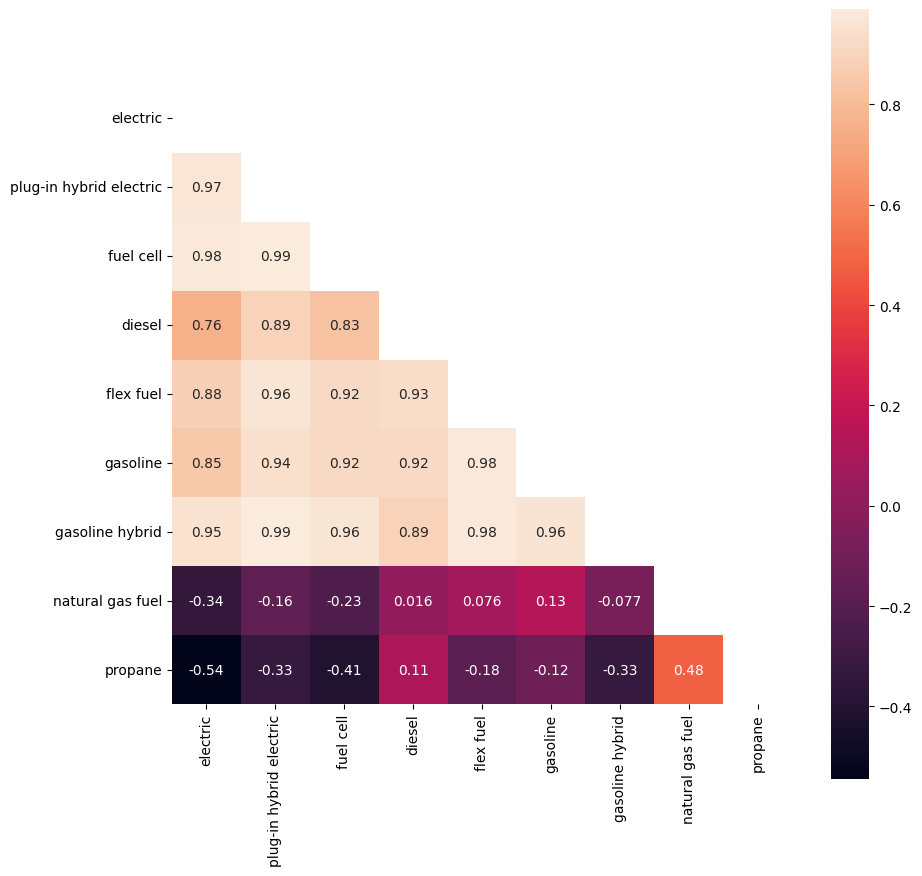

In [8]:
correlation = df.corr(method = 'pearson')
plt.subplots(figsize = (10,10))
masked = np.triu(np.ones_like(correlation, dtype=bool)) 
sns.heatmap(correlation,mask=masked,square = True, annot = True)

**Linear regression**

In [9]:
for fuel in fuel_types:
  if fuel != 'electric':
    X = df["electric"]
    y = df[fuel]

    slope, intercept, r, p, std_err = stats.linregress(X, y)

    def lin_func(X):
      return slope * X + intercept

    print(f'Electric and {fuel} correlation coefficient: {r}')

Electric and plug-in hybrid electric correlation coefficient: 0.9662769023657738
Electric and fuel cell correlation coefficient: 0.9785768553458403
Electric and diesel correlation coefficient: 0.7620211811090198
Electric and flex fuel correlation coefficient: 0.8805838314622024
Electric and gasoline correlation coefficient: 0.8480094316667867
Electric and gasoline hybrid correlation coefficient: 0.9508255094485304
Electric and natural gas fuel correlation coefficient: -0.3375779250306446
Electric and propane correlation coefficient: -0.5447756916685411


**Polynomial regression**

In [10]:
for fuel in fuel_types:
    if fuel != 'electric':
        X = df["electric"]
        y = df[fuel]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

        poly_model = np.poly1d(np.polyfit(X_train, y_train, 4))
        
        print(f'Electric and {fuel} training data score: {r2_score(y_train, poly_model(X_train))}; testing data score: {r2_score(y_test, poly_model(X_test))}')

Electric and plug-in hybrid electric training data score: 0.9991528183123052; testing data score: 0.9989066733313627
Electric and fuel cell training data score: 0.9944847333015716; testing data score: 0.9932973051679865
Electric and diesel training data score: 0.9912440131735002; testing data score: 0.9858590184378778
Electric and flex fuel training data score: 0.9856838578105517; testing data score: 0.9806442590671814
Electric and gasoline training data score: 0.9609045307522254; testing data score: 0.9351921651375406
Electric and gasoline hybrid training data score: 0.9925554355968267; testing data score: 0.9946603639850071
Electric and natural gas fuel training data score: 0.8620243189021104; testing data score: 0.8459056333266666
Electric and propane training data score: 0.9881564753710548; testing data score: 0.9854786690148635


if electric is 727150:
Total: 69205691
EVs represent 1.0507083811893985%
Number of plug-in hybrid electric vehicles: 842889 or 1.22%
Number of fuel cell vehicles: 60224 or 0.09%
Number of diesel vehicles: 0 or 0.0%
Number of flex fuel vehicles: 2186340 or 3.16%
Number of gasoline hybrid vehicles: 2192577 or 3.17%
Number of natural gas fuel vehicles: 27810 or 0.04%
Number of propane vehicles: 0 or 0.0%
Number of gasoline vehicles: 63895848 or 92.33%


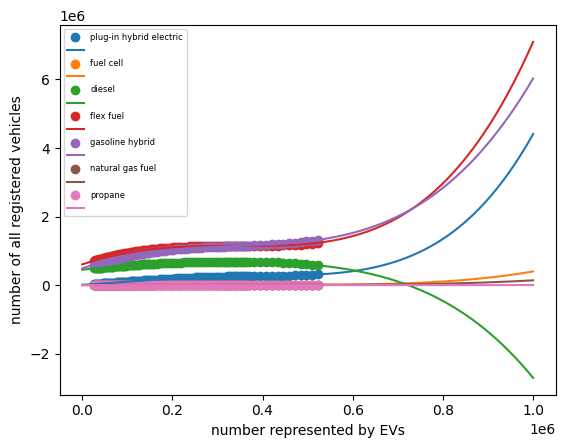

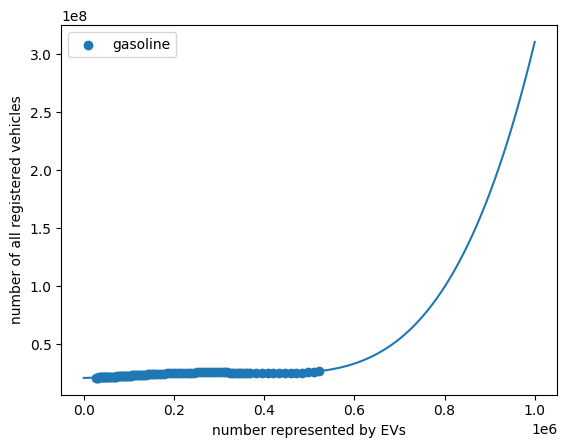

In [72]:
NUM_ELECTRIC = 727150
# 727150: 2.1212301629959134
print(f'if electric is {NUM_ELECTRIC}:')

legend = []
predictions = {}
for fuel in fuel_types:
    if fuel != 'electric' and fuel != 'gasoline':
        X = df["electric"]
        y = df[fuel]

        poly_model = np.poly1d(np.polyfit(X, y, 3))
        poly_line = np.linspace(0, 1000000, 1000)
        prediction = poly_model(NUM_ELECTRIC)
        if prediction < 0:
            prediction = 0
        predictions[fuel] = prediction
        # print(f'{fuel}: {prediction} or . (accuracy: {r2_score(y, poly_model(X))})')
        legend.append(fuel)
        legend.append('')
        plt.scatter(X,poly_model(X))
        plt.plot(poly_line, poly_model(poly_line))

# Gasoline
X = df["electric"]
y = df['gasoline']

poly_model = np.poly1d(np.polyfit(X, y, 3))
poly_line = np.linspace(0, 1000000, 1000)
# print(f'Electric and {fuel} accuracy: {r2_score(y, poly_model(X))}')
prediction = poly_model(NUM_ELECTRIC)
if prediction < 0:
    prediction = 0
# print(f'if electric is {NUM_ELECTRIC}: {prediction}')
predictions['gasoline'] = prediction

# Print results
total = sum(list(predictions.values()))
print(f'Total: {int(total)}')
print(f'EVs represent {NUM_ELECTRIC/total*100}%')
for entry in predictions:
    print(f'Number of {entry} vehicles: {int(predictions[entry])} or {round(predictions[entry]/total * 100,2)}%')

#522436	305309	10117	590218	1208964	1298265	8456	93

# Graph
plt.legend(legend,loc='upper left',prop={'size': 6},fontsize='large')
plt.ylabel('number of all registered vehicles')
plt.xlabel('number represented by EVs')
plt.show()

legend = ['gasoline']
plt.scatter(X,poly_model(X))
plt.plot(poly_line, poly_model(poly_line),label='gasoline')
plt.legend(legend,loc='upper left',prop={'size': 10})
plt.ylabel('number of all registered vehicles')
plt.xlabel('number represented by EVs')
plt.show()